In [1]:
# If you are reading this notebook on a Binder, make sure to right-click the file name in
# the left-side file viewer and select `Open With > Notebook` to view this as a notebook

# <i class="fas fa-book fa-fw"></i> Logistic Regression

In our last chapter on {doc}`../intro/index` we introduced the terminology of the classification, some first attempts at defining models for this scenario, and evaluation metrics for evaluating these models.

Our most successful model discussed so far was the Simple Linear Classifier. Recall that in the context of sentiment analysis, the goal of our linear classifier was to predict whether or not a sentence was positive or negative sentiment. We defined the predicted score of a sentence $x_i$ as $\hat{Score}(x_i) = \hat{w}^T h(x_i)$. If this score was positive, we predicted positive sentiment and if it was negative predicted negative sentiment.

The only detail we left out was how to learn its coefficients $\hat{w}$. With the story we saw so far in our regression setting, let's follow a similar path to discuss how to learn our parameters by using some optimization algorithm over some quality metric.

## Minimizing Classification Error

Intuitively, we would probably want to find the coefficients for our linear model that minimize some notion of classification error. Mathematically, we could write our goal is to minimize this quality metric:

$$\hat{w} = \argmin{w} \frac{1}{n}\sum_{i=1}^n \indicator{y_i \neq \hat{y}_i}$$

Just like with our regression setting, it is infeasible to try all possible settings of $w$, so instead we could hopefully use some optimization algorithm such as gradient descent to "roll down the hill" and find the best setting of our parameters. Unfortunately, that won't work here.

Recall that there were actually some pretty important assumptions about the function we wanted to optimize.

* The function we are optimizing has to be "bowl shaped" or *convex* so that the local optima is guaranteed to be the global optima (otherwise we get stuck at a sub-optimal valley)
* While we didn't discuss this in detail, we also need some basic qualities of our function to allow optimization such that the function is continuous and differentiable, so that it even makes sense to discuss computing the slope/gradient to "roll down the hill"

It turns out that classification error, has none of these desirable properties! Consider the following plot that shows the classification error as we vary a single parameter $w_1$. Depending on how many errors that line makes for that setting of $w_1$, its classification error will be lower or higher. The problem though is the errors don't change *continuously*. The error suddenly jumps up/down once the decision boundary crosses one of the training points. This causes a huge problem for gradient descent methods since there is no notion of smoothly "rolling down the hill" here. Every starting point looks like a stopping point because slightly changing the slope $w_1$ doesn't change the classification error!

```{figure} loss_function.png
:alt: A graph depicting that the classification error error metric does not have any of the nice properties we want for gradient descent (explained in last paragraph)
:align: center
```

So even though minimizing classification error seems like what we want to do, it's actually possible in practice. In order to fix this, we will have to slightly change our problem statement to make our problem one that we can optimize.

## Probability Predictions

Instead of only caring about the discrete outputs $\hat{y}_i = +1$ or $\hat{y}_i = -1$, we will move our discussion to the world of probabilities. In other words, we will ask the question "Given the sentence 'The sushi and everything else were awesome', what is the probability this sentence is a positive review?" To notate this mathematically, we are interested in the quantity

$$P(y = +1 | x = \text{"The Sushi and everything else were awesome"})$$

For a sentence as clearly positive as this one, we might expect this probability to be quite high, maybe more than 0.99!

But for more ambiguous sentences, we might not be certain either way and the probability of a positive review is lower. For example we might consider another example.

$$P(y = +1 | x = \text{"The sushi was alright, the service was OK"}) \approx 0.5$$

Note that we could also ask the question of what is the probability of a negative review $P(y = -1 | x)$. But since there are only two outcomes, there is 1:1 relationship between positive/negative review probabilities as shown in the equation below. This means we can always switch which probabilities we are discussing by subtracting them from 1.

$$P(y = +1 | x) + P(y = -1 | x) = 1$$

This leads us to a notion of a classifier that utilizes these probabilities.

```{prf:algorithm} Probability-based Classifier
:label: probability-classifier

**Input** A sentence $x$, and some model to predict $\hat{P}(y = +1 | x)$

**Output** A class $\hat{y} = +1$ or $\hat{y} = =1$

1. Estimate probability of positive review $p \gets \hat{P}(y = +1 | x)$
2. If $p > 0.5$
    1. $\hat{y} = +1$
3. else
    1. $\hat{y} = -1$
```

One benefit of this approach is by modifying this procedure to also report $\hat{P}(y = +1|x)$, it makes our model a bit more interpretable because we get a notion of confidence in the model's predictions.

While this is all well and good in theory, we still haven't answered how to exactly learn a model to match probabilities instead of just matching labels.

## Logistic Regression

### Scores to Probabilities: A Sigmoid Approach

What if the scores we were trying to learn for our Simple Linear Classifier could actually help us define some notion of probability? In theory the scores we were learning encoded some notion of a sliding scale between positive/negative. The scores could range from extremely negative numbers to extremely positive numbers. What if we could just change the units of the Scores so they would be ranged between the values of probabilities of 0s to 1s.

What we would need is some transformation from the units of scores (which could range from $-\infty$ to $\infty$) to the units of probabilities (which range from $0$ to $1$). Our interpretation of the scores are as follows:

* When the score is very negative (near $-\infty$), we are very sure the predicted label should be $\hat{y} = -1$ and therefore the $\hat{P}(y = +1 | x ) \approx 0$.
* When the score is very positive (near $\infty$), we are very sure the predicted label should be $\hat{y} = +1$ and therefore the $\hat{P})y = +1 | x) \approx 1$.
* When the score is near zero, we aren't very sure either way and we could say $\hat{P}(y = +1 | x) \approx 0.5$.

There are many functions that can compress the range of a number from $(-\infty, \infty)$ to $(0, 1)$, but the one we will discuss in detail is the **sigmoid** or the **logistic function**.

The sigmoid is defined as follows.

$$sigmoid(z) = \frac{1}{1 + e^{-z}}$$

In our case, the inputs of the function will be the scores themselves. So we will try as our probability model

$$P(y = +1 | x) = sigmoid(Score(x)) = \frac{1}{1 + e^{-Score(x)}}$$

Note that this function has all of the properties we want to convert from scores to probabilities. We show some examples of this functions outputs in the table below, and in the figure below that, plot out its shape.

```{table} Example outputs for Logistic Function
:name: logistic-outputs

| $Score(x)$ | $sigmoid(Score(x))$                                                                                 |
|------------|-----------------------------------------------------------------------------------------------------|
| $-\infty$  | $\frac{1}{1 + e^{--\infty}} = \frac{1}{1 + e^\infty} = \frac{1}{1 + \text{large number}} \approx 0$
| $-2$       | $\frac{1}{1 + e^{--2}} \approx 0.12$
| $0$        | $\frac{1}{1 + e^{-0}} = \frac{1}{1 + 1} = 0.5$
| $2$        | $\frac{1}{1 + e^{-2}} \approx 0.88$
| $-\infty$  | $\frac{1}{1 + e^{-\infty}} = \frac{1}{1 + 1/e^\infty} = \frac{1}{1 + \text{number near 0}} \approx 1$
```

```{figure} logistic.png
:alt: Graph of the s-curve shape of logistic regression
:width: 60%
:align: center
```

### Logistic Regression Model

So with this idea of how we can transform scores to probabilities, we can now arrive at our important **Logistic Regression** model. Recall that the $\hat{Score}(x)$ is determined by our learned coefficients $\hat{w}$, so it's appropriate to notate that our probability are a function of which coefficients we choose $w$.

$$P(y_i = +1 | x_i, w) = sigmoid(Score_w(x_i)) = \frac{1}{1 + e^{-w^Th(x_i)}}$$

We can then use this in our **Logistic Regression** model

```{prf:algorithm} Logistic Regression Classifier
:label: logistic-classifier

**Input** A sentence $x$, and our learned coefficients $\hat{w}$

**Output** A class $\hat{y} = +1$ or $\hat{y} = =1$

1. Estimate probability of positive review $p \gets \hat{P}(y = +1 | x, \hat{w}) = sigmoid(\hat{w}^Th(x))$
2. If $p > 0.5$
    1. $\hat{y} = +1$
3. else
    1. $\hat{y} = -1$
```

It might help to visualize a bit what is going on here. Recall before that our untransformed $Score$ function was a linear function in terms of the inputs. Now, we are transforming all of the score outputs to now follow this S-curve of the logistic where high scores are near 1 and low scores are near zero. We can still imagine the same decision boundary, but now that decision boundary is when the probability is near 0.5 (score is near 0).

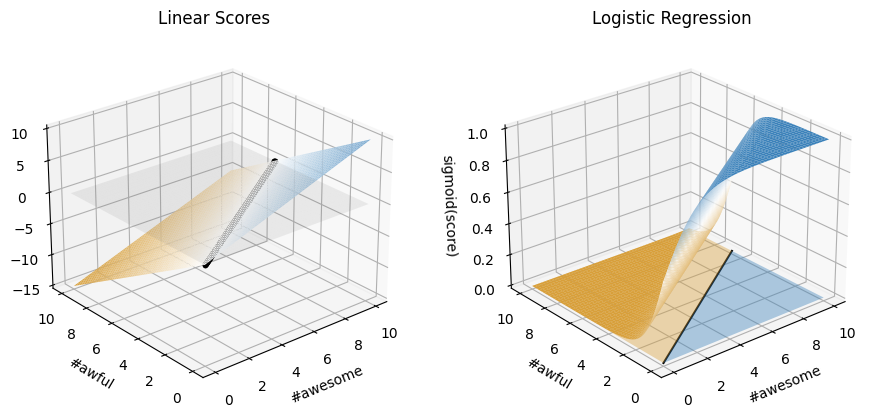

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Bunch of imports to get 3D plots
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Make our color scheme match our drawings from earlier
w = (0, 1, -1.5)

# Set up global plots
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom',
    [(0, '#D89F39'),
     (0.5, '#FFFFFF'),
     (1, '#3A81BA')], N=126)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
fig.tight_layout(pad=6.0)


def plot_score_function(ax):
    # Set up function and evalautes

    def z_function(x, y, w):
        return w[0] + w[1] * x + w[2] * y

    x = np.linspace(0, 10, 500)
    y = np.linspace(0, 10, 500)

    X, Y = np.meshgrid(x, y)
    Z = z_function(X, Y, w)

    # Make 3d plot
    ax.plot_surface(X, Y, Z, cmap=cmap, vmin=-15, vmax=15)
    ax.set_xlabel('#awesome')
    ax.set_ylabel('#awful')
    ax.set_zlabel('score')
    ax.view_init(25, 230)

    # Draw decision boundary
    ys = (-w[0] - w[1] * x) / w[2]
    ax.plot(x, ys, 0, '.', c='black')
    ax.plot_surface(X, Y, np.zeros(Z.shape), color='gray', alpha=0.1)

    ax.set_title("Linear Scores")


def plot_logistic_scores(ax):
    def z_function(x, y):
      return 1 / (1 + np.exp(-(w[0] + w[1] * x + w[2] * y)))

    x = np.linspace(0, 10, 500)
    y = np.linspace(0, 10, 500)

    X, Y = np.meshgrid(x, y)
    Z = z_function(X, Y)

    ax.plot_surface(X, Y, Z, cmap=cmap, vmin=0, vmax=1)
    ax.set_xlabel('#awesome')
    ax.set_ylabel('#awful')
    ax.set_zlabel('sigmoid(score)')
    ax.set_zlim(0, 1)
    ax.view_init(25, 230)

    # Draw shaded region for positive label
    pos = Poly3DCollection([[(0, 0, 0), (10, 0, 0), (10, 10/1.5, 0), (0,0,0)]])
    pos.set_alpha(0.4)
    pos.set_facecolor('#3A81BA')
    ax.add_collection(pos)

    # Draw shaded region for negative label
    neg = Poly3DCollection([[(0, 0, 0), (10, 10/1.5, 0), (10, 10, 0,), (0, 10, 0), (0,0,0)]])
    neg.set_alpha(0.4)
    neg.set_facecolor('#D89F39')
    ax.add_collection(neg)

    # Draw decision boundary
    ys = 1/1.5 * x
    ax.plot(x, ys, 0, c='black')

    ax.set_title("Logistic Regression")

plot_score_function(ax1)
plot_logistic_scores(ax2)
plt.show()

We'll come back to how to learn our coefficients in the next section, but before then, we want to show a bit of a practical example for how to use the scikit-learn library's implementation for Logistic Regression.

### Logistic Regression Code

Despite the complicated math in formulating the model, using a Logistic Regression model for classification in scikit-learn is just as easy as our normal Linear Regression model. We use the same `fit` and `predict` methods like before! There is an added method `predict_proba` to display what the probability of the predicted labels are.

The dataset we use is a cleaned version of an online dataset of product reviews from Amazon. While a huge part of a data scientist's task is pre-processing the data, we omit these steps to focus on the learning task.

In [3]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# For display
from IPython.display import display, Markdown

data = pd.read_csv("cleaned_products.csv")
display(Markdown("**Data**"))
display(data.head())

# Note we would also use a validation set if we wanted to
# choose a hyperparameter, but omit in this example
# random_state is to get consistent results
train_data, test_data = train_test_split(data, test_size=0.2, random_state=3)

# Transform the data to the bag of words model
# Important: Use the training data words to make bag-of-words counts for test
vectorizer = CountVectorizer()
vectorizer.fit(train_data["review"])  # Only count words in train set
train_counts = vectorizer.transform(train_data["review"])
test_counts = vectorizer.transform(test_data["review"])

# Train a model (random_state to get consistent results)
sentiment_model = LogisticRegression(random_state=1)
sentiment_model.fit(train_counts, train_data['sentiment'])

# Make predictions on data
train_predictions = sentiment_model.predict(train_counts)

display(Markdown("**Train Predictions** (first few examples)"))

print("Predictions", train_predictions[:5])
print("Actual     ", list(train_data["sentiment"][:5]))

# Make probability predictions
# Returns a 2D array of [Negative Prob, Positive Prob]
train_prob_predictions = sentiment_model.predict_proba(train_counts)
print("Probability", train_prob_predictions[:5, 1])

# Evaluate accuracy of model
display(Markdown("**Model Accuracy**"))
test_predictions = sentiment_model.predict(test_counts)

print("Train Accuracy", accuracy_score(train_data["sentiment"], train_predictions))
print("Test  Accuracy", accuracy_score(test_data["sentiment"], test_predictions))

**Data**

,sentiment,review
0,-1,I should have stayed with Idahoan brand Poor B...
1,1,As the pasta cooked I read the box to see what...
2,1,I really like this cereal The flavor is slight...
3,-1,The label on the bowl says 35 grams is in the ...
4,-1,Doesnt taste like ginger Thought it would sav...


**Train Predictions** (first few examples)

Predictions [ 1 -1 -1  1  1]
Actual      [1, -1, -1, 1, 1]
Probability [0.89974777 0.14569628 0.16639926 0.95383164 0.98689545]


**Model Accuracy**

Train Accuracy 1.0
Test  Accuracy 0.7415730337078652


```{admonition} Important: Data Transformations
:class: warning

Note in the example above, we had to use the same process to convert our data in the bag of words model from our train set to our test set. This is the same idea as why we had to normalize our data with the training statistics! Any data transformations you do have to be done entirely from the training set and no other outside data.
```

Now that we have seen how to use Logistic Regression in practice, let's discuss the procedure for learning our coefficients $\hat{w}$ that result in our probability predictions.

## Maximum Likelihood Estimation (MLE)

While this switch to probability is nice, it is not the only change we have to make in order to learn our coefficients $\hat{w}$. In particular, it's still not possible to minimize our classification error quality metric, even in the setting with probabilities. You might think of trying to move this back to a regression setting with using the MSE quality metrics with probabilities, but it turns out this also doesn't work in practice since the assumptions we made for our regression setting don't quite apply here in this bounded probability setting.

Instead, we have to change the question we care to optimize a bit. Instead of minimizing some notion of error with our concepts of probabilities, what if we use those probabilities as our measure of fit. In particular, we want our probabilities to "line up" with the true labels of the data. In other words, when the true label of an example is $y_i = +1$, we want $\hat{P}(y_i = +1 | x_i, \hat{w})$ to be high. On the other hand, when $y_i = -1$ we want $\hat{P}(y_i = +1 | x_i, \hat{w})$ to be low (conversely $\hat{P}(y_i = -1 | x_i, \hat{w})$ to be high). If we can find the coefficients $\hat{w}$ that make these probabilities "line up", then our hope is that those coefficients are good coefficients. Note that this sounds a bit like minimizing error, and it is kind of like that, but is slightly different since we are just trying to find coefficients that are likely to explain the data we saw.

This brings us to to the concept of **likelihood** (also called **likelihood functions**). The concept of a likelihood is exactly the concept we explained above. The likelihood measures, given a setting of coefficients we interested in exploring $w$, how likely that setting of the coefficients explains the training data we have.

Consider just a single training point $(x_i, y_i)$. We can define the likelihood $\ell_i(w)$ to explain how likely seeing label $y_i$ for input $x_i$ when using coefficients $w$. Notation-wise, we use the following to address the likelihood for a single data point to simplify the if/else condition if we care about the probability of a positive label or probability of a negative label.

$$
  \ell_i(w) = \hat{P}(y_i | x_i, w) = \begin{cases}
        \hat{P}(y_i = +1 | x_i, w) & \text{if } y_i = +1\\
        \hat{P}(y_i = -1 | x_i, w) & \text{if } y_i = -1
  \end{cases}
$$

```{margin}
{{ref_logistic_properties}}\. Note that because $P(y = +1|x) + P(y = -1|x) = 1$, we can derive the formula for the probability of the negative label by $P(y=-1|x) = 1 - P(y=+1|x)$.
```

Recall the probabilities are determined by our sigmoid function, so more explicitly, we have the following<sup>{{ref_logistic_properties}}</sup>.

$$
  \ell_i(w) = \hat{P}(y_i | x_i, w) = \begin{cases}
        \frac{1}{1 + e^{-w^Th(x_i)}} & \text{if } y_i = +1\\
        \frac{e^{-w^Th(x_i)}}{1 + e^{-w^Th(x_i)}}& \text{if } y_i = -1
  \end{cases}
$$

The intuition for this formula matches our description above. If the label is a positive label, the likelihood for our coefficients is higher if the probability of a positive label it predicts is larger. Similarly, if the label is a negative label, the likelihood is higher is the probability of a negative label is higher.

```{margin}
{{ref_product}}\. 📝 *Notation*: The $\Pi$ notation is a cumulative product just like $\sum$ is a cumulative sum.
```

But we don't care about just one data point, so instead we define the likelihood for our entire training dataset $\ell(w)$ as the following<sup>{{ref_product}}</sup>. Recall this definition has that hidden if-statement from our definition above to check the probability that matches the label of the training point.

$$\ell(w) = \hat{P}(y_1|x_1, w) \cdot \hat{P}(y_2|x_2, w)\cdot ... \cdot \hat{P}(y_n|x_n, w) = \Pi_{i=1}^n \hat{P}(y_i | x_i, w)$$

The intuition for this measure is that the the likelihood of our coefficients $w$ is high when the probabilities "line up" with the true labels. For example, consider the following graph of a small dataset and two candidates settings of coefficients $w^{(1)}$ and $w^{(2)}$.

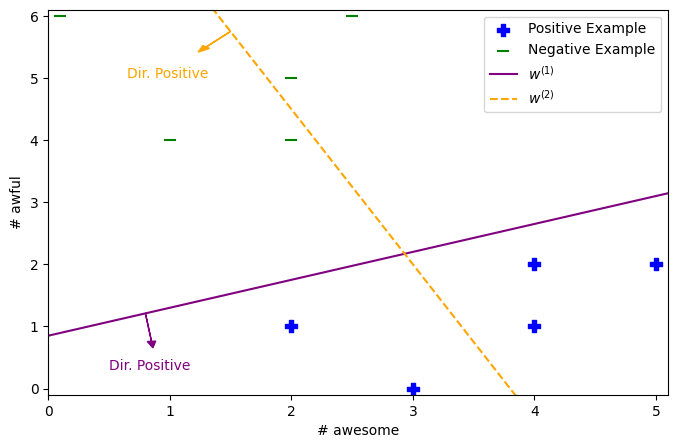

In [4]:
import matplotlib.pyplot as plt
import numpy as np

positive_data = np.array([
    [3, 0],
    [2, 1],
    [4, 1],
    [4, 2],
    [5, 2]
])

negative_data = np.array([
    [0.1, 6],
    [2.5, 6],
    [2, 5],
    [2, 4],
    [1, 4]
])

# Find min/max of data above (to be flexible)
min_x = min(np.min(positive_data[:, 0]), np.min(negative_data[:, 0]))
max_x = max(np.max(positive_data[:, 0]), np.max(negative_data[:, 0]))
min_y = min(np.min(positive_data[:, 1]), np.min(negative_data[:, 1]))
max_y = max(np.max(positive_data[:, 1]), np.max(negative_data[:, 1]))

# Make lines for classifier

def boundary1(xs):
    return 0.45 * xs + 0.85

def boundary2(xs):
    return 9.5 - 2.5 * xs

xs = np.linspace(min_x - 0.5, max_x + 0.5, 100)
line_1 = boundary1(xs)
line_2 = boundary2(xs)

# Make plots
fig, ax = plt.subplots(1, figsize=(8, 5))

# Plot data
ax.scatter(positive_data[:, 0], positive_data[:, 1], marker="P", color="b", s=80, label="Positive Example")
ax.scatter(negative_data[:, 0], negative_data[:, 1], marker="_", color="g", s=80, label="Negative Example")

# Plot boundaries
ax.plot(xs, line_1, color="purple", label="$w^{(1)}$")
ax.plot(xs, line_2, color="orange", linestyle="--", label="$w^{(2)}$")

# Plot indicators for positive direction (somewhat hardcoded for simplicty)
ax.arrow(0.8, boundary1(0.8), 0.05, -0.45, color="purple", head_width=0.07)
ax.annotate("Dir. Positive", xy=(0.5, 0.3), color="purple")

ax.arrow(1.5, boundary2(1.5), -0.2, -0.25, color="orange", head_width=0.07)
ax.annotate("Dir. Positive", xy=(0.65, 5), color="orange")

# Customize plot
ax.set_xlim((min_x - 0.1, max_x + 0.1))
ax.set_ylim((min_y - 0.1, max_y + 0.1))
ax.set_xlabel("# awesome")
ax.set_ylabel("# awful")
_ = ax.legend()

If you went through and did the math, the likelihood of $w^{(1)}$ would be higher than $w^{(2)}$ because its probability outputs are more "lined up" with the true labels. The second set of coefficients makes low-probability predictions of the correct labels on some points since they are on the opposite side of the decision boundary (i.e., more likely to be the opposite label). So the nice thing is this likelihood has some intuition like classification error, but it is a smoother notion since we are rewarding settings of $w$ that have probabilities that are closer to the true labels.

So with all of this discussion in mind, you might start to realize that we care about *maximizing* this likelihood $\ell(w)$ as a way of finding the "best" coefficients. So mathematically, our optimization problem would the following **maximum likelihood estimator**.

$$\hat{w} = \argmax{w} \ell(w) = \argmax{w} \Pi_{i=1}^n \hat{P}(y_i|x_i, w)$$

While this works in theory, in practice we tend to not optimize the likelihood directly. Recall that all of the probabilities are between 0 and 1. So multiplying a bunch of numbers between 0 and 1 over a dataset with, say, 10000 examples would become vanishingly small; so small that our computer may run into errors of precision. Instead we commonly will optimize the **log-likelihood** because it is computationally more convenient. Note that the coefficients that maximize the log-likelihood will also maximize the likelihood, since $\log$ is a monotonically increasing function. Also note that the property of the logarithm $\log(ab) = \log(a) + \log(b)$ turns our problem into one of sums instead of products.

$$\hat{w} = \argmax{w} \log(\ell(w)) = \argmax{w} \sum_{i=1}^n \log\left(\hat{P}(y_i|x_i, w)\right)$$

It turns out that this quality metric has all of the properties we want in our quality metric to use a gradient-based algorithm for finding the optimum. Before discussing this, we want to show one last way of formulating this log-likelihood quality metric that you might see in practice.

Remember that our quality metric has a hidden if-statement in there with our notation of $\hat{P}(y_i|x_i, w)$. That means you really have to compute the probabilities for positive/negative examples differently, so it sometimes helps to be explicit and write out the formula for all of the computations we need. So by separating or examples into positive and negative ones, and plugging in our formulas for our probabilities, we have a finalized and fully-detailed description of our quality metric.

$$\hat{w} = \argmax{w} \sum_{i=1; y_i = +1}^n \log\left(\frac{1}{1 + e^{-w^Th(x_i)}}\right) + \sum_{i=1; y_i = -1}^n \log\left(\frac{e^{-w^Th(x_i)}}{1 + e^{-w^Th(x_i)}}\right)$$

## Gradient Ascent

As we alluded to, we care about *maximizing* this quality metric, so an algorithm like gradient descent won't quite work here. It turns out though, that we have a completely analogous algorithm called **gradient ascent** that "walks up that hill" instead of "rolling down the hill". The ideas an computations for the algorithm are exactly the same, except we follow the slope/gradient of the function since that points in the direction of steepest ascent.


```{prf:algorithm} Gradient Ascent
:label: grad-ascent

1. Start at some (random) point $w^{(0)}$ at $t = 0$
2. While we haven't converged:

    1. Compute gradient at current point (direction of ascent) $d \gets \nabla \log\left(P(y_i|x_i, w)\right)$
    2. Update point $w^{(t + 1)} \gets w^{(t)} + \eta d$
    3. Update time $t \gets t + 1$
3. Output current $w^{(t)}$
```
Again, we do an addition instead of a subtraction from {prf:ref}`grad-descent` since the slope/gradient points in the direction of increase.

Note that there are necessary conditions for gradient ascent, to guarantee it converges to a meaningful optimum. Just like with gradient descent, we need the function to be continuous and differentiable. Instead of needing the function to be "bowl like" (*convex*) for gradient descent, we need the function to be "hill like" (*concave*) in gradient ascent.

```{figure} likelihood.png
---
alt: A visualization of the likelihood "hill"
width: 75%
align: center
---
```


So that's great, we basically understand this algorithm now because of its mirror relationship to gradient descent. Now that we have introduced both of these optimization algorithms, let's discuss in detail what this extra hyperparamter $\eta$ or the **learning rate**  or the **step size** affects these gradient algorithms.

### Step Size

```{admonition} Note

While technically we are discussing gradient ascent here, everything we discuss in this section applies to gradient descent as well.
```

At a high level, $\eta$ (pronounce "eta") is the step-size that is responsible for how far we move at each step of our gradient ascent algorithm. If $\eta$ is larger, we take a larger step at each iteration of the algorithm, if $\eta$ is smaller, we take smaller steps.

<!-- TODO Animations would be really good in this section -->

We can see the effect of how $\eta$ impacts the quality of the model we learn, by looking at how our quality metric improves as we let the algorithm run for longer and longer iterations.

```{figure} grad_ascent_just_right.png
---
alt: Plot of quality metric value as # iterations increases and with an eta that is "just right" causing the quality metric to improve steadily
width: 100%
align: center
---
```

As you can imagine, if we make $\eta$ smaller, we will still steadily climb up the hill but at a much slower pace. This will still be guaranteed to find the top of the hill, but might require a huge number of iterations to get there if $\eta$ is too small.

```{figure} grad_ascent_small.png
---
alt: With a smaller eta, the rate we converge to the optimum is much slower
width: 100%
align: center
---
```

On the other hand, if we make $\eta$ larger we can hopefully reach the top of the hill faster. The plot below shows a run of gradient ascent with a larger $\eta$ and we do see it reaches a higher value of the quality metric sooner. Note the spiky behavior at the beginning of the training. This happens because our step size is so large it hops to "the other side of the hill." This can potentially cause drops in our quality metric objective if we stepped a little too far and ended up further down than where we started. In this case $\eta$ was large enough to cause a bit of jumping around, but we eventually converge to the optimum.

```{figure} grad_ascent_larger.png
---
alt: With a larger eta, the rate we converge to the optimum is much faster with some "turbulance"
width: 100%
align: center
---
```

But if we make $\eta$ much larger, this "jumping to the other side of the hill" can get so extreme that every time we step, we get *further away* from the optimum! In this extreme case, we will never converge because we are always jumping way too far away. This problem is exacerbated by the fact that the size of the step is not only controlled by $\eta$, but also the magnitude of the slope/gradient at that point. With concave functions, the slopes are generally larger the farther you are away from the optimum, so our stepping further away causes an even larger jump on the next step, causing us to be even further away! Note the other choices of $\eta$ are shown in the plot below, and you can't even tell the difference between how they converge to the optimum compared to just *how bad* this large setting of $\eta$ is!

```{figure} grad_ascent_too_large.png
---
alt: With a much larger eta, we never converge
width: 100%
align: center
---
```

How do you choose the right step-size then? Just like most of our other hyperparameters, *you just have to guess and check a lot of options to see which one does best on some validation set*. This won't make complete sense why we need a validation set to figure out a detail of our optimization algorithm that seemingly has no effect on the model itself, we'll see later on that certain model types tend to overfit as we let them train longer and longer on our training set.

A good rule of thumb for trying out learning rates is to try values that are **exponentially spaced** to get a wider range of values you are trying. So instead of trying out $\eta = 1, 2, 3, ...$, try $\eta = 10^{-5}, 10^{-4}, ..., 1, 10, 100, ...$. That gives you a ballpark of what is the right order of magnitude for your task, and you can explore more values near the right order of magnitude.

A more advanced approach is to use a **decreasing step-size** as the gradient ascent algorithm runs. We tend to find this divergence from the optimum to happen as we approach the optimal point with a step size that is too large. So one clever fix to this is to decrease the step-size as the algorithm runs to hopefully prevent this. We just have to choose some starter step size $\eta_0$ and then at each iteration $t$, use a step-size like the following (or some other transformation that makes the value smaller over time).

$$\eta_t = \frac{\eta_0}{t}$$

### Grid Search

As we highlighted that for most hyperparameters, the most common algorithms are ones that just try all of the options. What about when we want to choose settings for multiple hyperparameters? For example, what if we want to choose the best learning rate $\eta$ and the best Ridge regularization constant $\lambda$?

Unfortunately, it is not sufficient to find the the best setting of $\eta$ using one cross validation experiment, and then in another cross validation experiment, find the best option for $\lambda$. That procedure is only guaranteed to work if you know the settings of $\eta$ and $\lambda$ have independent on the effects of the model. Unfortunately, it is quite hard to make that argument for most hyperparamters. Most hyperparameters have complex effects on our model's behaviors, and it's possible there is some complex relationship between how our hyperparamters effect each other even if we can't find some intuitive relationship between them.

What that means, is in practice you have to try *all combinations* of your hyperparameter values together. This algorithm is often called **Grid Search** because it has to try out a grid of all pairs of hyperparameters. For example, suppose we wanted to try the following values for $\eta$ and $\lambda$.

* $\eta_t \in [0.001, 0.01, 0.1, 1, \frac{1}{t}, \frac{10}{t}]$
* $\lambda \in [0.01, 0.1, 1, 10, 100]$

Then in total we would have to try 30 combinations of these hyperparamters ($5 \cdot 6 = 30$). That is a lot of models to try out and train even for just 5 choices of $\lambda$ and 6 for $\eta_t$.

<!-- TODO add good example for GridSearchCV? -->
It is often tedious to write out code to try all of the options, so scikit-learn provides a [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class that does cross validation on all possible settings of hyperparameters you might care to optimize.

## Logistic Regression and Overfitting

In the concluding sections of this chapter, we want to circle back to our discussion of overfitting and Logistic Regression. We will see a lot of similarities in how overfitting works in our classification setting with Logistic Regression as we did in our module on regression. We won't spend much of our time re-hashing the details of overfitting we already know, and will focus more on the effects of overfitting specifically in this new setting.

<!-- TODO cit figure once we have them in the text -->
Logistic Regression is still a linear model, by default, because the decision boundary it learns is still linear. However, just like this didn't stop us making Linear Regression more complex, we can do the same with Logistic Regression. One way to learn a more complicated decision boundary, is to use more complex features such as a bi-gram encoding of our text, using polynomial expansions of our features, or any other transformations you can think of to add more complicated features. Generally adding more features and more complex features will mean our resulting model is more complicated.

<!-- TODO I think writing this as a code example with output would be good. Right now it looks kinda ugly too-->

Suppose we had a simplified example of our positive/negative sentiment data, and we just trained it on the counts directly in a simple Logistic Regression Model. If we did that, we would find reasonably sized coefficients. On the right, the graph above shows the raw scores (not applied through the sigmoid) and the picture below shows the resulting decision boundary.

`````{grid}
````{grid-item}
:columns: 12

**Coefficients, Score Function, and Decision Boundary for model with linear features**
````
````{grid-item}
```{table}
:name: logistic-coeffs-1

| Feature  | Value  | Coefficient |
|----------|--------|-------------|
| $h_0(x)$ | 1      | 0.23        |
| $h_1(x)$ | $x[1]$ | 1.12        |
| $h_2(x)$ | $x[2]$ | -1.07       |
```
````
````{grid-item}
```{figure} boundary1.png
---
alt: A logistic regression decision boundary with linear features
align: center
---
```
````
`````

In the figures below, we will show the same figures with increasingly complex feature representations.

`````{grid}
````{grid-item}
:columns: 12

**Coefficients, Score Function, and Decision Boundary for model with quadratic features**
````
````{grid-item}
```{table}
:name: logistic-coeffs-2

| Feature  | Value    | Coefficient |
|----------|----------|-------------|
| $h_0(x)$ | 1        | 1.68        |
| $h_1(x)$ | $x[1]$   | 1.39        |
| $h_2(x)$ | $x[2]$   | -0.59       |
| $h_3(x)$ | $x[2]^2$ | -0.17       |
| $h_4(x)$ | $x[2]^2$ | -0.96       |
```
````
````{grid-item}
```{figure} boundary2.png
---
alt: A logistic regression decision boundary with quadratic features
align: center
---
```
````
`````

`````{grid}
````{grid-item}
:columns: 12

**Coefficients, Score Function, and Decision Boundary for model with degree 6 features**
````
````{grid-item}
```{table}
:name: logistic-coeffs-3

| Feature     | Value    | Coefficient |
|-------------|----------|-------------|
| $h_0(x)$    | 1        | 21.6        |
| $h_1(x)$    | $x[1]$   | 5.3         |
| $h_2(x)$    | $x[2]$   | -42.7       |
| $h_3(x)$    | $x[2]^2$ | -15.9       |
| $h_4(x)$    | $x[2]^2$ | -48.6       |
| $h_5(x)$    | $x[2]^3$ | -11.0       |
| $h_6(x)$    | $x[2]^3$ | 67.0        |
| $h_7(x)$    | $x[2]^4$ | 1.5         |
| $h_8(x)$    | $x[2]^4$ | 48.0        |
| $h_9(x)$    | $x[2]^5$ | 4.4         |
| $h_{10}(x)$ | $x[2]^5$ | -14.2       |
| $h_{11}(x)$ | $x[2]^6$ | 0.8         |
| $h_{12}(x)$ | $x[2]^6$ | -8.6        |
```
````
````{grid-item}
```{figure} boundary3.png
---
alt: A logistic regression decision boundary with degree 6 features
align: center
---
```
````
`````

`````{grid}
````{grid-item}
:columns: 12

**Coefficients, Score Function, and Decision Boundary for model with degree 20 features**
````
````{grid-item}
```{table}
:name: logistic-coeffs-4

| Feature     | Value       | Coefficient                           |
|-------------|-------------|---------------------------------------|
| $h_0(x)$    | 1           | 8.7                                   |
| $h_1(x)$    | $x[1]$      | 5.1                                   |
| $h_2(x)$    | $x[2]$      | 78.7                                  |
| ...         | ...         | ...                                   |
| $h_{11}(x)$ | $x[2]^6$    | -7.5                                  |
| $h_{12}(x)$ | $x[2]^6$    | <span style="color: red">3803</span>  |
| $h_{13}(x)$ | $x[2]^7$    | 21.1                                  |
| $h_{14}(x)$ | $x[2]^7$    | <span style="color: red">-2406</span> |
| ...         | ...         | ...                                   |
| $h_{37}(x)$ | $x[2]^{19}$ | $-2\cdot10^{-6}$                      |
| $h_{38}(x)$ | $x[2]^{19}$ | -0.15                                 |
| $h_{39}(x)$ | $x[2]^{20}$ | $-2\cdot10^{-8}$                      |
| $h_{40}(x)$ | $x[2]^{20}$ | 0.03                                  |
```
````
````{grid-item}
```{figure} boundary4.png
---
alt: A logistic regression decision boundary with degree 20 features
width: 100%
align: center
---
```
````
`````

So just with regression, we can see all of the following properties are shared with classification models as well.

* Models that have more features / more complicated features tend to be more more complicated. For classification, this means that the decision boundaries look more complex.
* The coefficients in more complicated models tend to have larger magnitudes.
* (Not seen in images above) More complicated models tend to overfit to their training data and generalize poorly.

In fact, we see the same relationship with classification in terms of its types of errors that we saw with regression in the plot of our error curves below based on model complexity.

```{figure} error_curves.png
---
alt: The same training vs true error curves
width: 100%
align: center
---
```

Now all of this is essentially stuff we have seen before, but there is one other important artifact of overfitting in classification that should be understood: **overconfident predictions**. Recall that our logistic regression model can give us a sense of how confident its predictions are based on the probability outputs. A probability closer to 0 or 1 indicate a sense of certainty that the example should have the label it does. Consider the 4 models we showed above, but showing the probability it predicts for the labels displayed as a color hue around the decision space.

```{figure} prob_predictions.png
---
alt: Decision boundaries for the last 4 pictures, but showing probability predictions instead. Big take-away is there are very few moderately-confident predictions in the overfit models.
width: 100%
align: center
---
```

In each of these images, the region of uncertainty near the decision boundary where the probability of being either label is near 0.5 shrinks as the model becomes more overfit. It is nice for our models to be certain when they can be, but when something is near the decision boundary, it is healthy to have a little bit of skepticism that your prediction is certainly correct when it's possible your decision boundary just happened to be on the wrong side of the decision due to noise. So in our simpler models, we see a healthy region of uncertainty around the decision boundary that shrinks as we increase the polynomial degree of the features. So in classification, seeing most predictions having extreme probabilities is yet another symptom of overfitting.

We will note that this symptom is actually a direct result of the coefficients getting larger in magnitude. With larger magnitudes, we tend to have scores that are also large in magnitude. When applied through our sigmoid function, those large magnitude scores get output as probabilities near 0 or near 1.

## Logistic Regression and Regularization

While overfitting is completely possible in classification models too, we have a lot of tools under our toolbelt to control for it. If we want to control for overfitting, we can use simpler models, generally done with:
* Using simpler features in the first place
* Regularization

We can regularize the Logistic Regression model with a regularizer such as the L1 norm $\norm{w}_1$ or the L2 norm $\norm{w}_2^2$! The great thing is that all of the properties we understand about L1 Regularization (LASSO) and L2 Regularization (Ridge) in the regression setting apply here for Logistic Regression. Refer back to {doc}`../../regression/ridge/index` and {doc}`../../regression/lasso/index` for more details on the effects of regularization on our learned models including how choosing the regularization penalty $\lambda$ affects the model and how to choose the right setting of $\lambda$.

The one minor details that differs that we should note is the exact formulation of the regularized quality metric. Note that in our setting where we are now *maximizing* a function, we will want to *subtract* our regularizer term to make the overfit models look worse when compared by the regularized quality metric. For example, using Logistic Regression with the L2 norm regularizer would optimize the following regularized version of the likelihood:

$$\hat{w} = \argmax{w}\log(\ell(w)) - \lambda \norm{w}_2^2$$

## Recap

In this chapter, we introduced our first complete classification model with Logistic Regression. Along the way, we introduced some important ideas to go along with the concept.

* Predicting with probabilities
* Using the logistic/sigmoid function to convert scores to probabilities
* Logistic Regression
* Minimizing error vs. maximizing likelihood
* Gradient Ascent
* Effects of changing $\eta$, step size, learning rate
* Overfitting with logistic regression
* Regularization with logistic regression